In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.datasets as sd
import sklearn.model_selection as ms
import scipy.linalg as sl
import numpy as np
import PIL


# Load MNIST data
Each image is represented by a 28 by 28 array of unsigned ints (0-255)

In [4]:
mnist = sd.fetch_mldata("MNIST original")
data, target = mnist.data, mnist.target
data[3].reshape(28, 28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  73, 253, 227,  73,  21,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  73, 251, 251, 251, 174,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

split data in to training set (60,000 observations) and testing set (10,000)

In [5]:
data_train, data_test, target_train, target_test = ms.train_test_split(data, target, train_size=60000, 
                                                                       test_size=10000, stratify=target)

## display a few sample digits

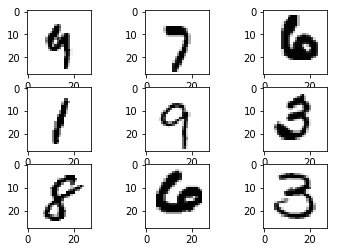

In [15]:
fig, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        img = data[np.random.randint(len(data))]
        ax = axes[i][j]
        ax.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)
        

# Preprocessing
First, we'll write a function for finding the bounding box of each image

In [20]:
def find_bbox(img):
    """
    Finding bounding box of image
    
    Returns:
    min_col, max_col, min_row, max_row
    
    """
    img = img.astype(float)
    cols = np.any(img, axis=0)
    rows = np.any(img, axis=1)
    
    min_col, max_col = np.where(cols)[0][[0, -1]]
    min_row, max_row = np.where(rows)[0][[0, -1]]
    
    return min_col, max_col, min_row, max_row

def plot_bbox(img):
    """
    Plot bounding box for an image
    """
    
    min_col, max_col, min_row, max_row = find_bbox(img)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axvline(min_col, color='r')
    ax.axvline(max_col, color='r')
    ax.axhline(min_row, color='r')
    ax.axhline(max_row, color='r')
    
    

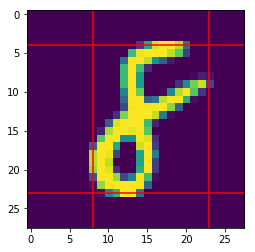

In [56]:
img = data_train[802].reshape(28, 28)
plot_bbox(img)

Now try to determine if an image is rotated.  There are many fancy ways of trying to determine if an image is skewed (eg, https://en.wikipedia.org/wiki/Image_moment#Raw_moments).  Here, we'll keep things simple and look for a rotation that yields a bounding box with the max height to width ratio.

In [66]:
def find_bbox_dimensions(img):
    """
    Return bbox dimensions for image
    
    Returns
    height, width
    
    """
    min_col, max_col, min_row, max_row = find_bbox(img)
    height = max_row - min_row
    width = max_col - min_col
    
    return height, width

def rotate_image(img, angle=0):
    """
    Rotate image by angle
    
    """
    if angle == 0:
        return img
    
    pimg = PIL.Image.fromarray(img)
    pimg = pimg.rotate(angle, resample=PIL.Image.BILINEAR)
    img = np.array(pimg)

    return img
        
def find_best_bbox_angle(img, min_angle=-45, max_angle=45, angle_step=5):
    """
    Find angle that results in a bbox with the highest height to width ratio
    
    """
    res = dict()
    for angle in range(min_angle, max_angle + angle_step, angle_step):
        rotated = rotate_image(img, angle)
        height, width = find_bbox_dimensions(rotated)
        res[angle] = height / width
    
    best_angle = max(res, key=res.get)
    
    # don't bother rotating if best angle is not much better than no rotation
    if (res[best_angle] / res[0]) < 1.1:
        best_angle = 0

    return best_angle



Now let's see how this sample image looks after we "deskew" it

best rotation angle: 20%


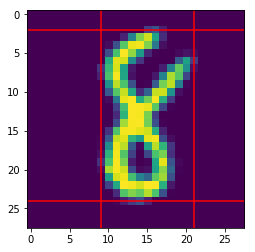

In [67]:
img = data_train[802].reshape(28, 28)
best_angle = find_best_bbox_angle(img)
print("best rotation angle: {}%".format(best_angle))
plot_bbox(rotate_image(img, best_angle))

In [41]:
max(res, key=res.get)


25

In [16]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()

In [17]:
clf.fit(data_train, target_train)

/anaconda3/envs/notebook/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [18]:
clf.score(data_test, target_test)

0.8689

# Data augmentation

In [ ]:
import PIL

In [ ]:
sample = data_train[34222].reshape(28, 28)
img = PIL.Image.fromarray(sample)
plt.imshow(img)

In [ ]:
plt.imshow(sample)

# Deskewing images

In [ ]:
def raw_moment(data, i_order, j_order):
  nrows, ncols = data.shape
  y_indices, x_indicies = np.mgrid[:nrows, :ncols]
  return (data * x_indicies**i_order * y_indices**j_order).sum()

def moments_cov(data):
  data_sum = data.sum()
  m10 = raw_moment(data, 1, 0)
  m01 = raw_moment(data, 0, 1)
  x_centroid = m10 / data_sum
  y_centroid = m01 / data_sum
  u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
  u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
  u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
  cov = np.array([[u20, u11], [u11, u02]])
  return cov

def determine_image_skew(data):
    cov = moments_cov(data)
    evals, evecs = sl.eigh(cov)
    
    x_v1, y_v1 = evecs[:, 1]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, 0]
    theta = np.tanh((x_v1)/(y_v1))
    
    return theta

def deskew_image(img):
    angle = determine_image_skew(img)
    pimg = PIL.Image.fromarray(img)
    pimg = pimg.rotate(-100 * angle)
    img = np.array(pimg)
    return img



In [ ]:
angle = determine_image_skew(sample)
angle

In [ ]:
angle

In [ ]:
plt.imshow(sample)


In [ ]:
plt.imshow(deskew_image(deskew_image(sample)))